# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


---
### Why We're Here 

In this notebook, we will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  This project will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling. 


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write My Own Algorithm
* [Step 6](#step6): Test My Own Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it at location `/lfw`.  

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [35]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


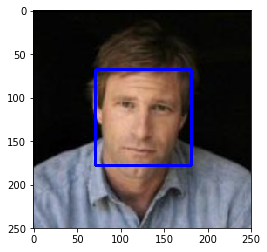

In [36]:
import cv2                
import matplotlib.pyplot as plt
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [37]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

__Question 1:__ 
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face. We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
1. 96% of the first 100 images in `human_files` have a detected human face.
2. 18% of the first 100 images in `dog_files` have a detected human face.

In [38]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_is_dog = np.zeros(len(human_files_short))
dog_is_human = np.zeros(len(dog_files_short))
human_is_dog_ratio = dog_is_human_ratio = 0.0
for i in range(0, len(human_files_short)):
    if face_detector(human_files_short[i]):
        human_is_dog[i] = 1

for i in range(0, len(dog_files_short)):
    if face_detector(dog_files_short[i]):
        dog_is_human[i] = 1

human_is_dog_ratio, dog_is_human_ratio = np.mean(human_is_dog), np.mean(dog_is_human)
human_is_dog_ratio, dog_is_human_ratio

(0.96, 0.18)

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [5]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

This function accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model. The output should always be an integer between 0 and 999, inclusive.

In [6]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    transform = transforms.Compose([transforms.Resize((224, 224)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
    
    image = Image.open(img_path)
    image = transform(image)
    image = image.unsqueeze_(0)
    image = image.cuda()

    output = VGG16(image)
    _, pred = torch.max(output, 1)
    
    
    return pred # predicted class index

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we noticed that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

In [7]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    index = VGG16_predict(img_path)
    if index <= 268 and index >= 151:
        return True
    return False # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ 
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
1. 0% of the images in `human_files_short` have a detected dog.
2. 94% of the images in `dog_files_short` have a detected dog.

In [8]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_is_dog = np.zeros(len(human_files_short))
dog_is_dog = np.zeros(len(dog_files_short))
human_is_dog_ratio = dog_is_dog_ratio = 0.0
for i in range(0, len(human_files_short)):
    if dog_detector(human_files_short[i]):
        human_is_dog[i] = 1

for i in range(0, len(dog_files_short)):
    if dog_detector(dog_files_short[i]):
        dog_is_dog[i] = 1

human_is_dog_ratio, dog_is_dog_ratio = np.mean(human_is_dog), np.mean(dog_is_dog)
human_is_dog_ratio, dog_is_dog_ratio

(0.0, 0.94)

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds from Scratch

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Our vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Specify Data Loaders for the Dog Dataset

In [18]:
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
use_cuda = torch.cuda.is_available()

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

transform_train = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                     ])

transform_valid = transforms.Compose([transforms.Resize(256), 
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                     ])

transform_test = transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                    ])

train_dir = 'dogImages/train/'
valid_dir = 'dogImages/valid/'
test_dir = 'dogImages/test/'

train_data = datasets.ImageFolder(train_dir, transform = transform_train)
valid_data = datasets.ImageFolder(valid_dir, transform = transform_valid)
test_data = datasets.ImageFolder(test_dir, transform = transform_test)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers, shuffle=False)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


**Question 3:** 
- How does my code resize the images (by cropping, stretching, etc)?  What size did I pick for the input tensor, and why?
- Did I decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:
I only applied data augmentation (RandomResizedCrop and RandomHorizontalFlip) to the training data to provide randomness, avoiding overfitting as much as possible. I've made the all 224 * 224, thus the sizes of the images would be consistent throughout the process. I have also normalized all images and converted them to Tensors.

### Model Architecture

In [26]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 133)
        
        self.dropout = nn.Dropout(0.5)
        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 7 * 7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps to get to my final CNN architecture and my reasoning at each step.  

__Answer:__ 
I consulted VGG first then diverged from its structure. The first two convolutional layers would each downsize the image by 2, and the maxpooling layers as well, therefore downsizing the images by 32 in total. I refrained from going deeper than 128 layers because 256 layers didn't seem to improve the performance. I've also applied dropout to prevent overfitting. The dropout was originally 0.2, but since the performance had low training loss and high validation loss, I changed the dropout to 0.5. Following the convolutional layers and maxpooling layers, three fully connected layers were meant to predict the breed. 

### Specify Loss Function and Optimizer

Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [27]:
import torch.optim as optim

### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = optim.RMSprop(model_scratch.parameters(), lr=0.0001)

### Train and Validate the Model

Save the final model parameters at filepath `'model_scratch.pt'`.

In [28]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                                                                                            valid_loss_min,
                                                                                            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    # return trained model
    return model


# train the model
model_scratch = train(200, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.882871 	Validation Loss: 4.862508
Validation loss decreased (inf --> 4.862508).  Saving model ...
Epoch: 2 	Training Loss: 4.847345 	Validation Loss: 4.799882
Validation loss decreased (4.862508 --> 4.799882).  Saving model ...
Epoch: 3 	Training Loss: 4.775143 	Validation Loss: 4.687160
Validation loss decreased (4.799882 --> 4.687160).  Saving model ...
Epoch: 4 	Training Loss: 4.668544 	Validation Loss: 4.564122
Validation loss decreased (4.687160 --> 4.564122).  Saving model ...
Epoch: 5 	Training Loss: 4.595176 	Validation Loss: 4.498066
Validation loss decreased (4.564122 --> 4.498066).  Saving model ...
Epoch: 6 	Training Loss: 4.541129 	Validation Loss: 4.468355
Validation loss decreased (4.498066 --> 4.468355).  Saving model ...
Epoch: 7 	Training Loss: 4.491674 	Validation Loss: 4.409819
Validation loss decreased (4.468355 --> 4.409819).  Saving model ...
Epoch: 8 	Training Loss: 4.467767 	Validation Loss: 4.355479
Validation loss decreased (4.40981

Epoch: 166 	Training Loss: 2.852014 	Validation Loss: 2.490309
Epoch: 167 	Training Loss: 2.863767 	Validation Loss: 2.515192
Epoch: 168 	Training Loss: 2.865711 	Validation Loss: 2.461650
Validation loss decreased (2.481122 --> 2.461650).  Saving model ...
Epoch: 169 	Training Loss: 2.876841 	Validation Loss: 2.496684
Epoch: 170 	Training Loss: 2.871644 	Validation Loss: 2.472089
Epoch: 171 	Training Loss: 2.851207 	Validation Loss: 2.531078
Epoch: 172 	Training Loss: 2.843382 	Validation Loss: 2.494939
Epoch: 173 	Training Loss: 2.825240 	Validation Loss: 2.421463
Validation loss decreased (2.461650 --> 2.421463).  Saving model ...
Epoch: 174 	Training Loss: 2.836883 	Validation Loss: 2.481434
Epoch: 175 	Training Loss: 2.839480 	Validation Loss: 2.447827
Epoch: 176 	Training Loss: 2.801289 	Validation Loss: 2.446669
Epoch: 177 	Training Loss: 2.839750 	Validation Loss: 2.429621
Epoch: 178 	Training Loss: 2.806505 	Validation Loss: 2.436128
Epoch: 179 	Training Loss: 2.802461 	Valida

### Test the Model

In [29]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.849405


Test Accuracy: 31% (263/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds using Transfer Learning



### Specify Data Loaders for the Dog Dataset

In [26]:
## Specify data loaders
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
use_cuda = torch.cuda.is_available()

### Write data loaders for training, validation, and test sets
### Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

transform_train = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                     ])

transform_valid = transforms.Compose([transforms.Resize(256), 
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                     ])

transform_test = transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                    ])

train_dir = 'dogImages/train/'
valid_dir = 'dogImages/valid/'
test_dir = 'dogImages/test/'

train_data = datasets.ImageFolder(train_dir, transform = transform_train)
valid_data = datasets.ImageFolder(valid_dir, transform = transform_valid)
test_data = datasets.ImageFolder(test_dir, transform = transform_test)

data_transfer = {'train': train_data, 'valid': valid_data, 'test': test_data}

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers, shuffle=False)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


### Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Save the initialized model as the variable `model_transfer`.

In [11]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 

model_transfer = models.resnet50(pretrained=True)
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

)


In [12]:
for param in model_transfer.parameters():
    param.requires_grad = False

last_layer = nn.Linear(2048, 133, bias = True)
model_transfer.fc = last_layer

for param in model_transfer.fc.parameters():
    param.requires_grad = True

print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

)


In [13]:
if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps I took to get to my final CNN architecture and my reasoning at each step.  Describe why I think the architecture is suitable for the current problem.

__Answer:__ 
I picked ResNet because it performed well on Image Classification, and I think its "identity shortcuts" may prevent much overfitting. I replaced its fully-connected layer with an output of 133.

### Specify Loss Function and Optimizer

Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer`.

In [15]:
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr = 0.001)

### Train and Validate the Model

Save the final model parameters at filepath `'model_transfer.pt'`.

In [20]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                                                                                            valid_loss_min,
                                                                                            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    # return trained model
    return model


In [21]:
# train the model
model_transfer = train(30, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 4.833420 	Validation Loss: 4.678461
Validation loss decreased (inf --> 4.678461).  Saving model ...
Epoch: 2 	Training Loss: 4.608844 	Validation Loss: 4.444070
Validation loss decreased (4.678461 --> 4.444070).  Saving model ...
Epoch: 3 	Training Loss: 4.411724 	Validation Loss: 4.230695
Validation loss decreased (4.444070 --> 4.230695).  Saving model ...
Epoch: 4 	Training Loss: 4.227493 	Validation Loss: 4.035641
Validation loss decreased (4.230695 --> 4.035641).  Saving model ...
Epoch: 5 	Training Loss: 4.050879 	Validation Loss: 3.825584
Validation loss decreased (4.035641 --> 3.825584).  Saving model ...
Epoch: 6 	Training Loss: 3.884433 	Validation Loss: 3.663544
Validation loss decreased (3.825584 --> 3.663544).  Saving model ...
Epoch: 7 	Training Loss: 3.718460 	Validation Loss: 3.479158
Validation loss decreased (3.663544 --> 3.479158).  Saving model ...
Epoch: 8 	Training Loss: 3.572864 	Validation Loss: 3.310929
Validation loss decreased (3.47915

### Test the Model


In [23]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [24]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.326720


Test Accuracy: 77% (646/836)


### Predict Dog Breed with the Model

This function takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) predicted.

In [67]:
from PIL import Image
import torchvision.transforms as transforms

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([transforms.Resize((224, 224)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
    image = transform(image)
    image = image.unsqueeze_(0)

    output = model_transfer(image)
    idx = torch.argmax(output)
    
    return class_names[idx]

---
<a id='step5'></a>
## Step 5: Write My Own Algorithm

This algorithm accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


### (IMPLEMENTATION) Write your Algorithm

In [80]:
from PIL import Image
import torchvision.transforms as transforms

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    image = Image.open(img_path).convert('RGB')
    is_dog = dog_detector(img_path)
    is_human = face_detector(img_path)
    if (is_dog or is_human) is False:
        print("Error! Input image not a dog or human!")
        plt.imshow(image)
        plt.show()
        return None
    
    breed = predict_breed_transfer(img_path)
    
    if is_dog:
        print("Hello dog!")
    else: print("Hello human!")
    
    plt.imshow(image)
    plt.show()
    print("you look like a ... {}\n".format(breed))    


---
<a id='step6'></a>
## Step 6: Test My Own Algorithm


### Test Your Algorithm on Sample Images!



__Question 6:__ Is the output better than expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for my algorithm.

__Answer:__ 
The output is ok. Three possible points for improvement:
1. More data augmentation might improve the model's performance on test data.
2. Different ways of weight initializations might be helpful.
3. More training data, to a certain extent, might improve the model.

In [59]:
## Execute my algorithm from Step 6 on
## at least 6 images.

human_files = np.array(glob("my_images/human/*/*"))
dog_files = np.array(glob("my_images/dog/*/*"))
neither_files = np.array(glob("my_images/neither/*/*"))

for file in np.hstack((human_files[:3], dog_files[:3], neither_files[:3])):
    run_app(file)

Hello dog!


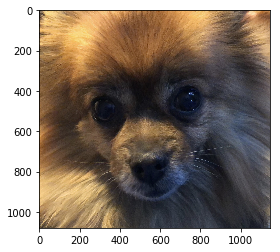

you look like a ... Pomeranian

Hello dog!


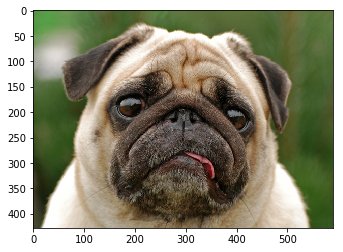

you look like a ... Bulldog

Hello dog!


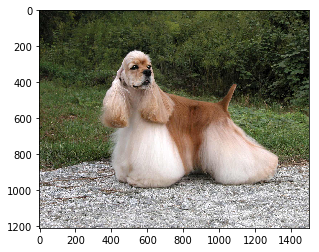

you look like a ... Afghan hound

Hello human!


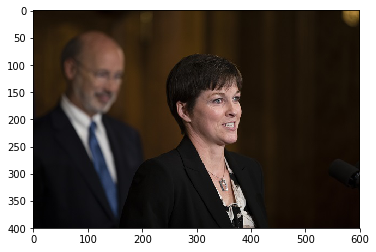

you look like a ... Poodle

Hello human!


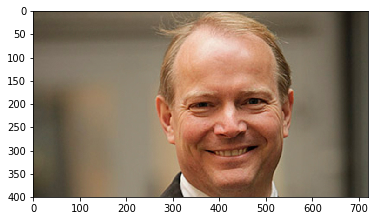

you look like a ... Bulldog

Hello human!


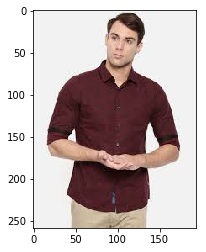

you look like a ... Basenji

Error! Input image not a dog or human!


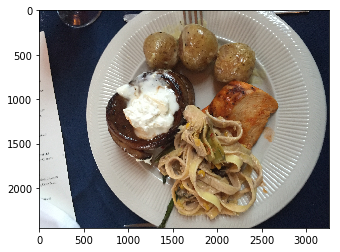

Error! Input image not a dog or human!


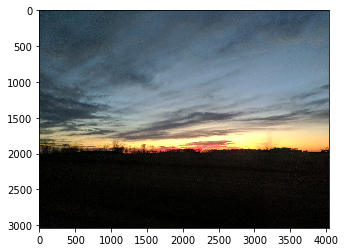

Error! Input image not a dog or human!


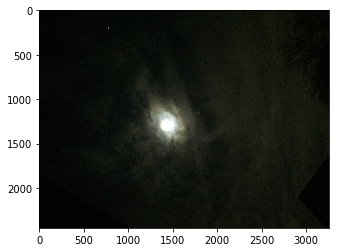

In [82]:
for img_file in os.listdir('./my_images'):
    img_path = os.path.join('./my_images', img_file)
    run_app(img_path)